This notebook reproduces an example of demographic parameter inference from simulated genomic data for a simple demographic model given 3 variable parameters (see below).

# Import

In [ ]:
import sys
import importlib
sys.path.append('./Simulations')
sys.path.append('./Demo_inference')
import default_settings as st
import modelling as md
import modelling_settings as mds
import pandas as pd
import numpy as np
import json
import seaborn as sns
import scipy

# Loading data

In this example, we aim to explore the inference of demographic parameters (Split_time, Migration_rate, N_ancestral) from statistical summaries of genomic data simulated for 2000 different scenarios.

In [2]:
data = pd.read_csv('./Demo_inference/sumstats_mean_locus.csv')

In [3]:
print("The ranges of the demographic parameters are:")
for param in ['T_split', 'migration_rate', 'N_ancestral']:
    print(f"    '{param}': {md.get_limit(param)}")

The ranges of the demographic parameters are:
    'T_split': [10, 2000]
    'migration_rate': [0, 0.001]
    'N_ancestral': [1000, 5000]


# Parameters

In [4]:
# Selection of a demographic parameter for performing complete inference, along with its characteristics (Y = 'T_split' or 'migration_rate' or 'N_ancestral')
Y = 'T_split'
# Define the size of the training set
train_size = 0.6

In [5]:
processing = md.preprocess_data(data, mds.var_tbr, Y, train_size)

Number of rows in the training set: 1200
Number of rows in the test set: 800


# Supervised machine learning model training and prediction

- **Main Hyperparameters of the ML models** (here to be changed : Demo_inference/modelling_parameters)

In [6]:
# Random forest
rf_params = md.get_rf_params(Y)

{
    "n_estimators": 50,
    "max_depth": 20,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
    "max_features": 0.5
}


In [7]:
# XGBoost
xgb_params = md.get_xgb_params(Y)

{
    "n_estimators": 50,
    "max_depth": 15,
    "subsample": 0.8,
    "colsample_bytree": 0.4
}


In [8]:
# Multilayer perceptron
mlp_params = md.get_mlp_params(Y)

{
    "hidden_layer_sizes": [
        2500,
        1000,
        500,
        100,
        50
    ],
    "activation": "relu",
    "solver": "adam",
    "batch_size": "auto",
    "max_iter": 100
}


- **Modelling**

In [9]:
rf, result_pred_rf = md.train_and_evaluate_rf(processing[0], processing[2], processing[1], processing[3], rf_params, Y, limit = md.get_limit(Y))

Test MSE : 87147.62589118838
Test RMSE : 295.2077673286873
Test MAE: 214.8370409099902
Test NMAE: 0.10795831201507046


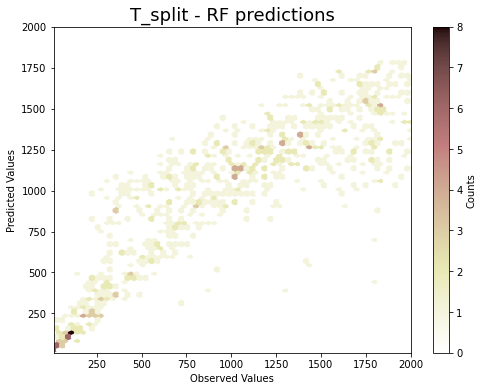

In [10]:
observed_values = result_pred_rf['Observed_target']
predicted_values =  result_pred_rf['Predicted_target']

md.create_hexbin_plot(observed_values, predicted_values,md.get_limit(Y),
                   title =  f'{Y} - RF predictions')

In [11]:
xgb_r, result_pred_xgb = md.train_and_evaluate_xgb(processing[4], processing[6], processing[5], processing[7], xgb_params, Y, processing[9], True, md.get_limit(Y))

Test MSE : 81539.97792388061
Test RMSE : 285.55205816782444
Test MAE: 207.53965678215027
Test NMAE: 0.10429128481515089


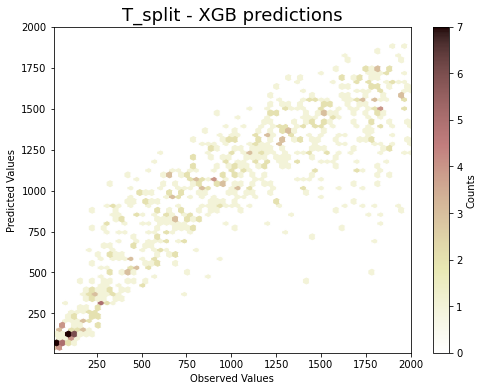

In [12]:
observed_values = result_pred_xgb['Observed_target']
predicted_values =  result_pred_xgb['Predicted_target']

md.create_hexbin_plot(observed_values, predicted_values,md.get_limit(Y),
                   title =  f'{Y} - XGB predictions')

In [13]:
mlp, result_pred_mlp = md.train_and_evaluate_mlp(processing[4], processing[6], processing[5], processing[7], mlp_params, Y, processing[9], True, md.get_limit(Y))

Test MSE for Random Forest: 67347.92312905172
Test RMSE for Random Forest: 259.514784027908
Test MAE for Random Forest: 170.58683400978938
Test NMAE for Random Forest: 0.08572202714059768


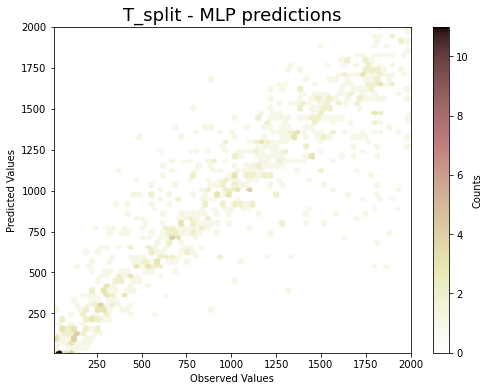

In [14]:
observed_values = result_pred_mlp['Observed_target']
predicted_values =  result_pred_mlp['Predicted_target']

md.create_hexbin_plot(observed_values, predicted_values,md.get_limit(Y),
                   title =  f'{Y} - MLP predictions')

## Features

In [15]:
importances_rf = md.compute_permutation_importances(rf, processing[1], processing[3])

In [16]:
importances_xgb = md.compute_permutation_importances(xgb_r, processing[1], processing[3])

In [17]:
importances_mlp = md.compute_permutation_importances(mlp, processing[1], processing[3])

- **Permutation feature importances by summary statistics (top 5)**

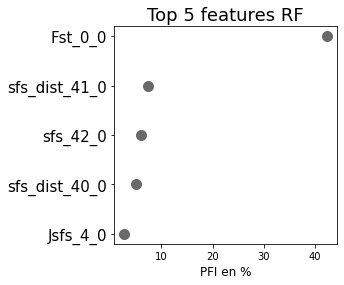

In [18]:
md.plot_top_features_scatter(md.standardize_importances(importances_rf), title = 'Top 5 features RF')

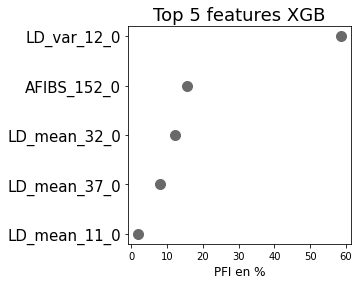

In [19]:
md.plot_top_features_scatter(md.standardize_importances(importances_xgb), title = 'Top 5 features XGB')

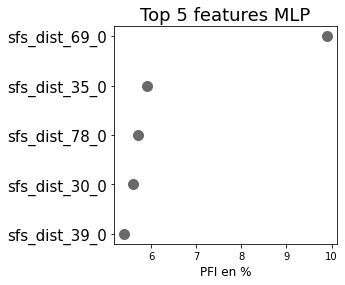

In [20]:
md.plot_top_features_scatter(md.standardize_importances(importances_mlp), title = 'Top 5 features MLP')

- **Comparison betwenn the three ML models.**

A comparison of the importances, warmer the color is, higher the importance is.

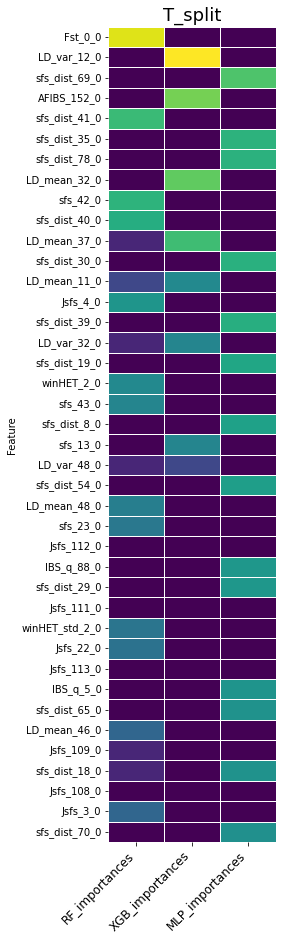

In [22]:
md.generate_importances_heatmap(md.standardize_importances(importances_rf), 
                             md.standardize_importances(importances_xgb), 
                             md.standardize_importances(importances_mlp), 
                             nb_values=40, title = Y)